In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import root
from tqdm import tqdm

# nice latex plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12
})

# color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def solve_poly(z, sigma, kappa):
    alpha = 1 / kappa
    R_noise = sigma
    a3 = np.sqrt(alpha) * R_noise
    a2 = -(np.sqrt(alpha) * z + R_noise)
    a1 = (z + np.sqrt(alpha) - alpha**(-1 / 2))
    a0 = -1

    # Coefficients of the polynomial
    coefficients = [a3, a2, a1, a0]

    # Find the roots of the polynomial
    return np.roots(coefficients)


def edges_rho(sigma, kappa):
    alpha = 1/kappa
    R_noise = sigma

    a0 = -12 * R_noise + (4 * R_noise) / alpha + 12 * alpha * R_noise - 4 * alpha**2 * R_noise - 20 * R_noise**2 + R_noise**2 / alpha - 8 * alpha * R_noise**2 - 4 * R_noise**3
    a1 = -(10 * R_noise) / np.sqrt(alpha) + 2 * np.sqrt(alpha) * R_noise + 8 * alpha**(3/2) * R_noise - (2 * R_noise**2) / np.sqrt(alpha) + 8 * np.sqrt(alpha) * R_noise**2
    a2 = 1 - 2 * alpha + alpha**2 + 8 * R_noise - 2 * alpha * R_noise + R_noise**2
    a3 = -2 * np.sqrt(alpha) - 2 * alpha**(3/2) - 2 * np.sqrt(alpha) * R_noise
    a4 = alpha

    # Coefficients of the polynomial
    coefficients = [a4, a3, a2, a1, a0]

    roots_all = np.roots(coefficients)
    real_roots = np.real(roots_all[np.abs(np.imag(roots_all)) < 1e-6])

    return np.sort(real_roots)


def rho(x, sigma, kappa):        
    return np.max(np.imag(solve_poly(x-1e-8j, sigma, kappa))) / np.pi

def integral_rho(Delta, kappa):
        
    def rho(x):        
        return np.max(np.imag(solve_poly(x-1e-8j, Delta, kappa))) / np.pi

    
    edges_list = edges_rho(Delta, kappa)

    if len(edges_list) == 4:
        return quad(lambda x: rho(x)**3, edges_list[0], edges_list[1])[0] + quad(lambda x: rho(x)**3, edges_list[2], edges_list[3])[0]
    else:
        return quad(lambda x: rho(x)**3, edges_list[0], edges_list[1])[0]



def f_RIE(R, Delta, kappa):
    Delta = Delta + 1e-6
    def denoiser(x):        
        choose_root = np.argmax(np.imag(solve_poly(x-1e-8j, Delta, kappa))) 
        return np.real(solve_poly(x-1e-8j, Delta, kappa))[choose_root]
    
    eigval, eigvec = np.linalg.eig(R)
    eigval_denoised = np.array([e - 2*Delta*denoiser(e) for e in eigval])
    return eigvec @ np.diag(eigval_denoised) @ eigvec.T


def F_RIE(Delta, kappa):
    return Delta - 4*np.pi**2/3 * Delta**2 * integral_rho(Delta, kappa)



# Spectrum test

(0.0, 1.0)

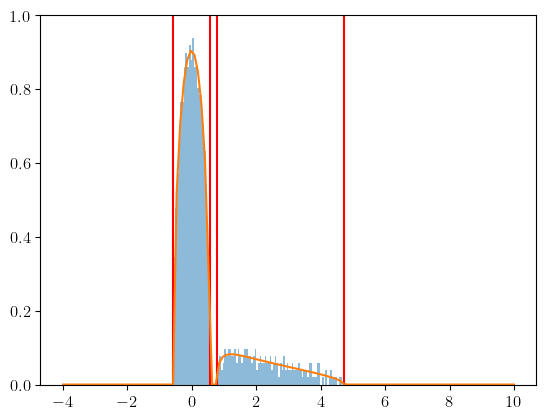

In [2]:
def datamodel_denoising(D, r, Delta):
    W = np.random.normal(0,1, (D, r))
    S = W @ W.T / np.sqrt(r)
    Z = np.random.normal(0,1, (D, D))
    Z = (Z + Z.T) / np.sqrt(2)
    Y = S + np.sqrt(Delta) * Z

    # Y is divided by the square root of D to have the eigenvalues of Y of order 1
    # S has the elements of order 1
    return S, Y / D**(1/2)



D = 1000
r = 200

noise = 0.1

S, Y = datamodel_denoising(D,r,Delta=noise)
S, U = np.linalg.eig(Y)


x = np.linspace(-4, 10, 128)
pdf = [rho(x, noise, r/D) for x in x]

plt.hist(S, bins=100, density=True, alpha=0.5)

# Vertical lines for the edges
edges = edges_rho(noise, r/D)
[plt.axvline(x=edge, color='r') for edge in edges]


plt.plot(x, pdf, label='Theoretical')

plt.ylim(0,1)

# Denoiser test

In [3]:
D = 1000
r = 500

noise = 0.6

S, Y = datamodel_denoising(D,r,Delta=noise)
S_hat = f_RIE(Y, noise, r/D) * np.sqrt(D)

MMSE_AMP = np.linalg.norm(S_hat - S)**2 / D**2
MMSE_theory = F_RIE(noise, r/D)

print(f"Theory: {MMSE_theory}, AMP: {MMSE_AMP}")

Theory: 0.2839021473693112, AMP: 0.2829918344198994


# Functions for AMP

In [4]:
def data_generation(D, beta, alpha, delta):
    R = int(beta * D)
    N = int(alpha * D**2)

    # X = np.random.normal(0,1, (N, D, D))
    X_mu = np.random.normal(0,1, (N,D))
    X = (np.einsum("mi,mj->mij", X_mu,X_mu) - np.einsum("ij,m->mij", np.eye(D), np.ones(N))) 

    W = np.random.normal(0,1, (D, R))
    S = W @ W.T / np.sqrt(R)

    h = np.einsum('mij,ij->m', X, S) / D
    y = h + np.sqrt(delta)*np.random.normal(0,1, N)
    # print(y.mean(), y.std())
    return X, y, S



In [5]:
def AMP(X, y, S, beta, iterations = 100, damping = 0.4, tol = 1e-5, verbose = False):
    def gOut(y, w, V):
        return (y-w)/(noise + V)

    N, D, _ = X.shape
    r = int(D*beta)
    alpha = N/D**2
        
    uX = X / np.sqrt(D) # X_mu has O(1) components and y_mu is O(1). We normalise X to have simpler equations later
        
    # hatS has O(1) SPECTRUM
    W = np.random.normal(0,1, (D, r))
    hatS = W @ W.T / np.sqrt(r) / np.sqrt(D) 

    if verbose:
        # print(f"==> Squared norm of iterate is {np.linalg.norm(hatS)**2 / D}, which is compatible with the theory: {1 + r/D}")
        print(f"==> Squared norm distance with true S is {np.linalg.norm(S - hatS*np.sqrt(D))**2 / D**2}")
        
    hatC    = 10.
    omega   = np.ones(N)*10.
    V       = 10.

    error = np.inf
    for t in range(iterations):
        newV = hatC
        newOmega = np.einsum("nij,ij", uX, hatS) - gOut(y, omega, V) * newV
        
        V = newV * (1-damping) + V * damping
        omega = newOmega * (1-damping) + omega * damping
        
        # Factor 2
        A_normalised = np.sum(gOut(y, omega, V)**2) * alpha / N * 2
        # print(A_normalised, 1/(1+V)*alpha)
        # A_normalised =  alpha / (1 + V)

        R = hatS + 1 / (A_normalised * D)  * np.sum(gOut(y, omega, V)[:, None, None] * uX, axis=0)
        
        # Factor 2
        noise_A = 1 / A_normalised / 2
        newhatS = f_RIE(R, noise_A, r/D)
        hatC = F_RIE(noise_A, r/D)  * 2
        
        error = np.linalg.norm(hatS - newhatS)**2 / D
        error_eval = np.linalg.norm(hatS*np.sqrt(D) - S)**2 / D**2
        hatS = newhatS

        if verbose:
            print(f"--> Squared norm distance of iteration step is {error}")
            print(f"--> Squared norm distance of true S is {error_eval}")
        
        if error < tol:
            break

    return hatS, error_eval

In [6]:
D = 50
r = int(100*0.1)

noise = 0.0
alpha = 0.5

X, y, S = data_generation(D, r/D, alpha, noise)

_, error_eval = AMP(X, y, S, r/D, verbose=True)
        
print(f"Error is {error_eval}")


==> Squared norm distance with true S is 2.3409838595061228
--> Squared norm distance of iteration step is 0.17150836954000664
--> Squared norm distance of true S is 2.3409838595061228
--> Squared norm distance of iteration step is 0.16908290534331605
--> Squared norm distance of true S is 1.9545593376161379
--> Squared norm distance of iteration step is 0.18627114368429062
--> Squared norm distance of true S is 1.5423703743665853
--> Squared norm distance of iteration step is 0.133330735964067
--> Squared norm distance of true S is 1.0898321005193103
--> Squared norm distance of iteration step is 0.058367852779631496
--> Squared norm distance of true S is 0.7635920447419808
--> Squared norm distance of iteration step is 0.021953518909883687
--> Squared norm distance of true S is 0.5563319404842959
--> Squared norm distance of iteration step is 0.0068134184891279785
--> Squared norm distance of true S is 0.43695149573349734
--> Squared norm distance of iteration step is 0.0017087008410

In [7]:
def AMP_experiment(D, alpha, beta, noise, samples = 2, iterations = 100, damping = 0.5, tol = 1e-5, verbose = False):
    errors = np.zeros(samples)
    for i in tqdm(range(samples)):
        X, y, S = data_generation(D, beta, alpha, noise)
        _, errors[i] = AMP(X, y, S, beta, iterations = iterations, damping = damping, tol = tol, verbose=False)

        if verbose:
            print(f"Error is {errors[i]}")
    return errors

D = 50
beta = 0.5
alpha = 0.5
noise = 0.0
samples = 2

errors = AMP_experiment(D, alpha, beta, noise, samples = samples, iterations = 100, damping = 0.5, tol = 1e-5, verbose=True)

print(f"Mean error is {errors.mean()} and std is {errors.std()}")

 50%|█████     | 1/2 [00:05<00:05,  5.30s/it]

Error is 0.00015103818627638493


100%|██████████| 2/2 [00:10<00:00,  5.29s/it]

Error is 0.00018168667805696596
Mean error is 0.00016636243216667544 and std is 1.5324245890290514e-05
